## Temporal Aggregation w/o Spatial Granularity (i.e., one number for the entire lake)

### Weekly Statistics

In [102]:
import os
os.getcwd()

'/home/jovyan/work/FinalProject/Algal_Data'

In [ ]:
import rasterio
import numpy as np
from glob import glob
import pandas as pd
from datetime import datetime, timedelta

# Input directory
input_dir = "Clipped2_Lake_Erie"

# Initialize lists to store weekly statistics
weekly_stats = {
    'startdate_extracted': [],
    'startdate_standard': [],
    'year': [],
    'month': [],
    'season': [],
    'mean_ci': [],
    'median_ci': [],
    'std_ci': [],
    'min_ci': [],
    'max_ci': [],
    'mean_dn': [],
    'median_dn': [],
    'std_dn': [],
    'min_dn': [],
    'max_dn': []
}

# Function to extract the date directly from the filename
def extract_date_from_filename(filename):
    # Example filename: L20162622016268.L3m_7D_CYAN_CI_cyano_CYAN_CONUS_300m_merged.tif
    # Extract the first date: 2016262 (Year + DOY)
    year_doy = filename.split('.')[0][1:8]  # Skip 'L' and take the next 7 characters
    year = int(year_doy[:4])
    doy = int(year_doy[4:])
    
    # Convert DOY to a standard date (e.g., 2016262 -> 2016-09-18)
    date = datetime(year, 1, 1) + timedelta(days=doy - 1)
    return year_doy, date

# Iterate through all `.tif` files
for file in sorted(glob(f"{input_dir}/*.tif")):
    try:
        # Extract the raw date string and converted standard date
        startdate_extracted, startdate_standard = extract_date_from_filename(file.split('/')[-1])
        year = startdate_standard.year
        month = startdate_standard.month
        season = (month % 12 // 3) + 1  # Winter=1, Spring=2, Summer=3, Fall=4

        with rasterio.open(file) as src:
            # Read the first band
            data = src.read(1)

            # Mask out invalid values (DN=254 and 255) and below-detection values (DN=0)
            valid_mask = (data < 254) & (data != 0)
            valid_data = data[valid_mask]  # Extract valid DN values

            # Ensure there is valid data to process
            if valid_data.size == 0:
                print(f"No valid data found in file: {file}. Skipping...")
                continue

            # Compute spatial statistics for DN
            mean_dn = np.mean(valid_data)
            median_dn = np.median(valid_data)
            std_dn = np.std(valid_data)
            min_dn = np.min(valid_data)
            max_dn = np.max(valid_data)

            # Convert DN to CI_cyano using the formula
            ci_cyano = 10 ** (valid_data * 0.011714 - 4.1870866)
            mean_ci = np.mean(ci_cyano)
            median_ci = np.median(ci_cyano)
            std_ci = np.std(ci_cyano)
            min_ci = np.min(ci_cyano)
            max_ci = np.max(ci_cyano)

            # Append results to the dictionary
            weekly_stats['startdate_extracted'].append(startdate_extracted)  # Use raw date from filename
            weekly_stats['startdate_standard'].append(startdate_standard.strftime('%Y-%m-%d'))  # Converted date
            weekly_stats['year'].append(year)
            weekly_stats['month'].append(month)
            weekly_stats['season'].append(season)
            weekly_stats['mean_ci'].append(mean_ci)
            weekly_stats['median_ci'].append(median_ci)
            weekly_stats['std_ci'].append(std_ci)
            weekly_stats['min_ci'].append(min_ci)
            weekly_stats['max_ci'].append(max_ci)
            weekly_stats['mean_dn'].append(mean_dn)
            weekly_stats['median_dn'].append(median_dn)
            weekly_stats['std_dn'].append(std_dn)
            weekly_stats['min_dn'].append(min_dn)
            weekly_stats['max_dn'].append(max_dn)

            # Print progress for large datasets
            print(f"Processed: {file}")
            print(f"Extracted Date: {startdate_extracted}, Standard Date: {startdate_standard}")
            print(f"Mean (DN): {mean_dn:.4f}, Median (DN): {median_dn:.4f}, Std (DN): {std_dn:.4f}")
            print(f"Min (DN): {min_dn}, Max (DN): {max_dn}, Mean CI_cyano: {mean_ci:.4e}")

    except Exception as e:
        print(f"Error processing file {file}: {e}")

# Create a DataFrame to store the weekly results
weekly_results = pd.DataFrame(weekly_stats)

# Ensure the `date_extracted` column is treated as integers for correct sorting
weekly_results['startdate_extracted'] = weekly_results['startdate_extracted'].astype(int)

# Sort the results by the `date_extracted` column in ascending order
weekly_results = weekly_results.sort_values(by='startdate_extracted', ascending=True)

# Save weekly results to a CSV file
weekly_results.to_csv("algal_weekly_statistics.csv", index=False)
print("Algal weekly statistics saved to `algal_weekly_statistics.csv`.")

### Monthly Statistics

In [35]:
# Create monthly statistics by year
monthly_stats = (
    weekly_results
    .groupby(['year', 'month'])
    .agg({
        'mean_ci': ['mean', 'std'],
        'median_ci': 'mean',
        'std_ci': 'mean',
        'min_ci': 'min',
        'max_ci': 'max',
        'mean_dn': ['mean', 'std'],
        'median_dn': 'mean',
        'std_dn': 'mean',
        'min_dn': 'min',
        'max_dn': 'max',
    })
    .reset_index()
)
monthly_stats.columns = ['_'.join(col).strip('_') for col in monthly_stats.columns.values]
monthly_stats.to_csv("algal_monthly_by_year_statistics.csv", index=False)
print("Algal monthly statistics saved to `algal_monthly_by_year_statistics.csv`.")

Algal monthly statistics saved to `algal_monthly_by_year_statistics.csv`.


### Seasonal Statistics

In [36]:
# Create seasonal statistics by year
seasonal_stats = (
    weekly_results
    .groupby(['year', 'season'])
    .agg({
        'mean_ci': ['mean', 'std'],
        'median_ci': 'mean',
        'std_ci': 'mean',
        'min_ci': 'min',
        'max_ci': 'max',
        'mean_dn': ['mean', 'std'],
        'median_dn': 'mean',
        'std_dn': 'mean',
        'min_dn': 'min',
        'max_dn': 'max',
    })
    .reset_index()
)
seasonal_stats.columns = ['_'.join(col).strip('_') for col in seasonal_stats.columns.values]
seasonal_stats.to_csv("algal_seasonal_by_year_statistics.csv", index=False)
print("Algal seasonal statistics saved to `algal_seasonal_by_year_statistics.csv`.")

Algal seasonal statistics saved to `algal_seasonal_by_year_statistics.csv`.


### Filter the 15-year timeframe (2009.1.1 - 2023.12.31)

In [37]:
# Weekly statistics
filtered_weekly_results = weekly_results[(weekly_results['year'] >= 2009) & (weekly_results['year'] <= 2023)]
filtered_weekly_results.to_csv("filtered_algal_weekly_statistics.csv", index=False)
print("Filtered weekly statistics saved to `filtered_algal_weekly_statistics.csv`.")

# Monthly statistics
filtered_monthly_stats = monthly_stats[(monthly_stats['year'] >= 2009) & (monthly_stats['year'] <= 2023)]
filtered_monthly_stats.to_csv("filtered_algal_monthly_statistics.csv", index=False)
print("Filtered monthly statistics saved to `filtered_algal_monthly_statistics.csv`.")

# Seasonal statistics
filtered_seasonal_stats = seasonal_stats[(seasonal_stats['year'] >= 2009) & (seasonal_stats['year'] <= 2023)]
filtered_seasonal_stats.to_csv("filtered_algal_seasonal_statistics.csv", index=False)
print("Filtered seasonal statistics saved to `filtered_algal_seasonal_statistics.csv`.")

Filtered weekly statistics saved to `filtered_algal_weekly_statistics.csv`.
Filtered monthly statistics saved to `filtered_algal_monthly_statistics.csv`.
Filtered seasonal statistics saved to `filtered_algal_seasonal_statistics.csv`.


### Seasonal Trend

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load seasonal statistics
seasonal_stats = pd.read_csv("filtered_algal_seasonal_statistics.csv")

# Inspect the DataFrame
print(seasonal_stats.head())

   year  season  mean_ci_mean  mean_ci_std  median_ci_mean  std_ci_mean  \
0  2009       1      0.000288     0.000150        0.000214     0.000217   
1  2009       2      0.003268     0.004358        0.003445     0.001472   
2  2009       3      0.008332     0.003209        0.007892     0.005110   
3  2009       4      0.004387     0.003528        0.003740     0.003292   
4  2010       1      0.000461     0.000174        0.000352     0.000368   

   min_ci_min  max_ci_max  mean_dn_mean  mean_dn_std  median_dn_mean  \
0    0.000067    0.004866     42.248870    19.713300       37.800000   
1    0.000067    0.017287    103.814961    52.641190      106.041667   
2    0.000067    0.059780    160.458218    24.898198      169.923077   
3    0.000067    0.042099    119.616674    42.026855      128.153846   
4    0.000067    0.001526     57.644444    15.966678       54.666667   

   std_dn_mean  min_dn_min  max_dn_max  
0    19.902639           1         160  
1    21.935440           1        

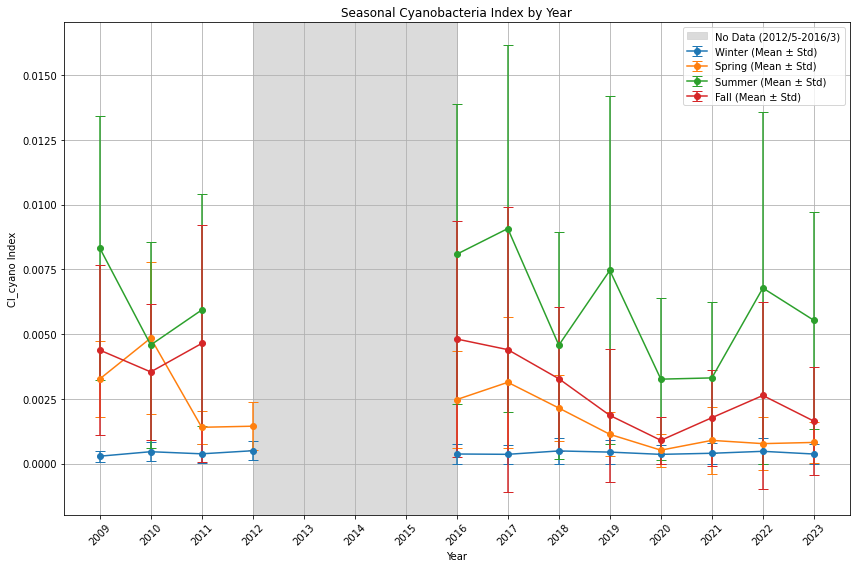

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Add NaN for missing years to break the line
for missing_year in [2013, 2014, 2015]:
    for season in [1, 2, 3, 4]:
        seasonal_stats = seasonal_stats.append({
            'year': int(missing_year),  # Ensure year is an integer
            'mean_ci_mean': np.nan, 
            'std_ci_mean': np.nan, 
            'season': season
        }, ignore_index=True)

# Sort the DataFrame by year to ensure proper ordering
seasonal_stats['year'] = seasonal_stats['year'].astype(int)  # Ensure all years are integers
seasonal_stats = seasonal_stats.sort_values('year')

# Map seasons to names for better visualization
season_names = {1: "Winter", 2: "Spring", 3: "Summer", 4: "Fall"}
seasonal_stats['season_name'] = seasonal_stats['season'].map(season_names)

# Plot setup
plt.figure(figsize=(12, 8))

# Plot for each season
for season in seasonal_stats['season_name'].unique():
    season_data = seasonal_stats[seasonal_stats['season_name'] == season]
    
    # Plot mean with error bars (std deviation)
    plt.errorbar(
        season_data['year'], season_data['mean_ci_mean'], yerr=season_data['std_ci_mean'],
        fmt='o-', label=f'{season} (Mean ± Std)', capsize=5
    )

# Highlight the missing data period (2013–2015) with a grey box
plt.axvspan(2012, 2016, color='lightgrey', alpha=0.8, label='No Data (2012/5-2016/3)', zorder=1)

# Customization: Add all years, including missing ones, to the x-axis
all_years = sorted(set(seasonal_stats['year']))
plt.xticks(ticks=all_years, labels=[str(year) for year in all_years], rotation=45)

# Titles and labels
plt.title('Seasonal Cyanobacteria Index by Year')
plt.xlabel('Year')
plt.ylabel('CI_cyano Index')
plt.legend()
plt.grid(True, zorder=0)
plt.tight_layout()

# Show the plot
plt.show()

### Monthly Trend

In [64]:
# Load seasonal statistics
monthly_stats = pd.read_csv("filtered_algal_monthly_statistics.csv")

# Inspect the DataFrame
print(monthly_stats.head())

   year  month  mean_ci_mean  mean_ci_std  median_ci_mean  std_ci_mean  \
0  2009      2      0.000505          NaN        0.000505     0.000000   
1  2009      3      0.000317     0.000174        0.000265     0.000191   
2  2009      4      0.000971     0.000636        0.000659     0.000782   
3  2009      5      0.006876     0.004881        0.007580     0.002792   
4  2009      6      0.012001     0.000457        0.012886     0.004276   

   min_ci_min  max_ci_max  mean_dn_mean  mean_dn_std  median_dn_mean  \
0    0.000505    0.000505     76.000000          NaN       76.000000   
1    0.000067    0.001263     48.134921    18.057642       47.166667   
2    0.000158    0.005568     84.862500    16.439048       82.500000   
3    0.000067    0.017287    152.384953    40.268958      160.200000   
4    0.000069    0.022036    187.351506     6.314918      196.000000   

   std_dn_mean  min_dn_min  max_dn_max  
0     0.000000          76          76  
1    21.404979           1         110  

<Figure size 1008x720 with 0 Axes>

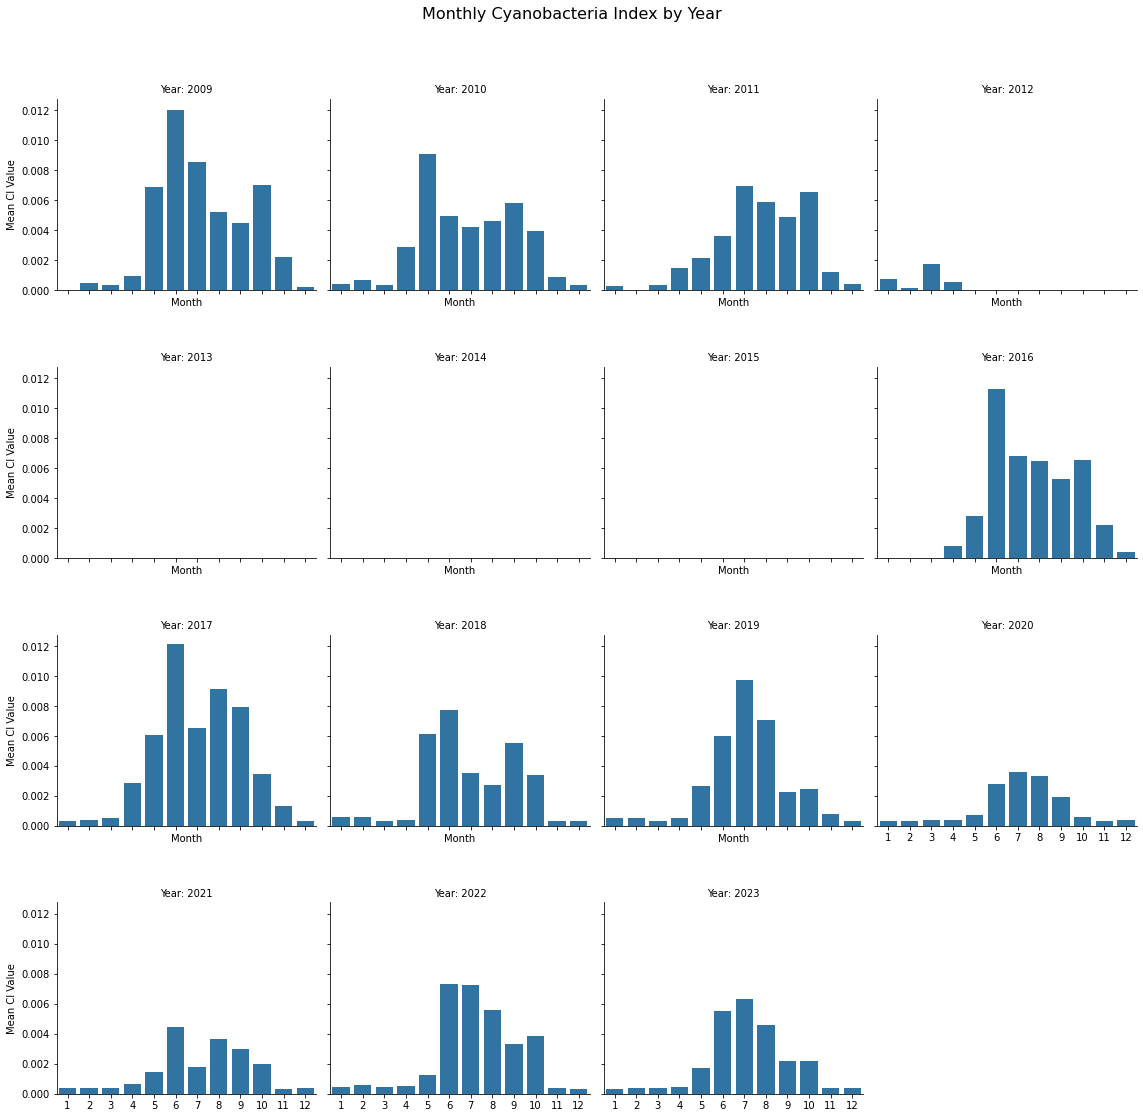

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the FacetGrid
plt.figure(figsize=(14, 10))
g = sns.FacetGrid(monthly_stats, col="year", col_wrap=4, height=4, sharey=True)
g.map(sns.barplot, "month", "mean_ci_mean", order=range(1, 13), ci=None)

# Customize each subplot's x-axis
for ax in g.axes.flatten():
    ax.set_xticks(range(12))  # Set x-ticks for 12 months
    ax.set_xticklabels(range(1, 13))  # Use 1, 2, ..., 12 as labels
    ax.set_xlabel("Month")  # Add x-axis label for each subplot

# Set a shared y-axis label
g.set_axis_labels("", "Mean CI Value")
g.set_titles("Year: {col_name}")  # Keep year-specific titles

# Adjust layout
plt.subplots_adjust(top=0.9, hspace=0.4)  # Adjust row spacing
g.fig.suptitle("Monthly Cyanobacteria Index by Year", fontsize=16)
plt.show()

The x-axis label and title are not working well.

<Figure size 1008x720 with 0 Axes>

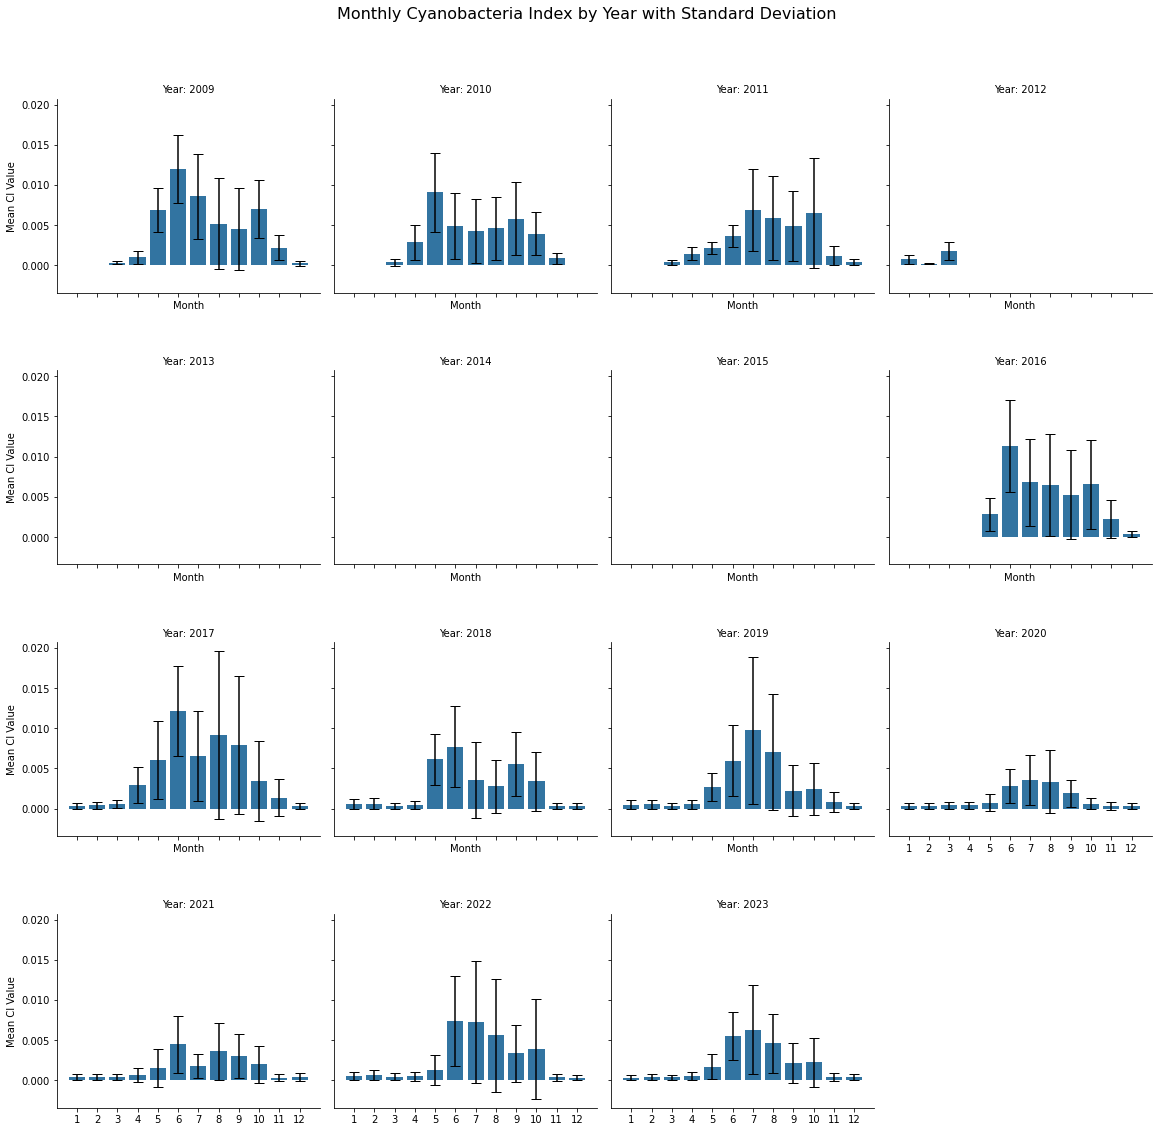

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the FacetGrid
plt.figure(figsize=(14, 10))
g = sns.FacetGrid(monthly_stats, col="year", col_wrap=4, height=4, sharey=True)

# Custom function for barplot with error bars
def plot_with_error(data, **kwargs):
    sns.barplot(
        x="month",
        y="mean_ci_mean",
        data=data,
        order=range(1, 13),
        ci=None,
        **kwargs
    )
    
    # Add error bars manually
    for index, row in data.iterrows():
        plt.errorbar(
            x=row["month"] - 1,  # Adjust x position for zero-based plotting
            y=row["mean_ci_mean"],
            yerr=row["std_ci_mean"],
            fmt="none",
            ecolor="black",
            capsize=5,
        )

# Map the custom function to the FacetGrid
g.map_dataframe(plot_with_error)

# Customize each subplot's x-axis
for ax in g.axes.flatten():
    ax.set_xticks(range(12))  # Set x-ticks for 12 months
    ax.set_xticklabels(range(1, 13))  # Use 1, 2, ..., 12 as labels
    ax.set_xlabel("Month")  # Add x-axis label for each subplot

# Set a shared y-axis label
g.set_axis_labels("", "Mean CI Value")
g.set_titles("Year: {col_name}")  # Keep year-specific titles

# Adjust layout
plt.subplots_adjust(top=0.9, hspace=0.4)  # Adjust row spacing
g.fig.suptitle("Monthly Cyanobacteria Index by Year with Standard Deviation", fontsize=16)
plt.show()

## Temporal Aggregation w/ Spatial Granularity

In [107]:
os.chdir("..")

In [108]:
ci_raster = rasterio.open("Algal_Data/Clipped2_Lake_Erie/L20162622016268.L3m_7D_CYAN_CI_cyano_CYAN_CONUS_300m_merged.tif")
ci_data = ci_raster.read(1)
rows, cols = np.meshgrid(np.arange(ci_data.shape[0]), np.arange(ci_data.shape[1]), indexing='ij')
x_coords, y_coords = rasterio.transform.xy(ci_raster.transform, rows, cols)

In [109]:
ci_flat = ci_data.flatten()
x_flat = np.array(x_coords).flatten()
y_flat = np.array(y_coords).flatten()
data = pd.DataFrame({
    'x': x_flat,
    'y': y_flat,
    'CI': ci_flat
})

print(data.head())

           x          y  CI
0 -83.512325  43.571225   0
1 -83.509072  43.571225   0
2 -83.505820  43.571225   0
3 -83.502567  43.571225   0
4 -83.499315  43.571225   0
